In [1]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.metrics import accuracy_score
from nltk.stem.porter import PorterStemmer
import spacy
import os

In [2]:
pd.options.mode.chained_assignment = None
nltk.download('stopwords')

file_prefix = 'hashtag'
text_field = 'hashtag'

[nltk_data] Downloading package stopwords to /Users/ashok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
csvname="filtered_dataset/"+file_prefix+".csv"
data_orig=pd.read_csv(csvname)
data=data_orig.copy()
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
rows=len(data)

In [4]:
def filter_text(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    oldtext=data[text_field][i] 
    newtext=' '.join(re.sub("(@[A-Za-z0-9]+)| (_URL_) | (#[A-Za-z0-9]+)|(\w+:\/\/\S+)"," ",str(oldtext)).split()) # removes hashtags, https links, usernames.
    newtext= re.sub('[^a-zA-Z0-9]'," ",str(newtext)) #removes all other characters other than English Alpha-Numeric Characters
    newtext=newtext.lower()
    newtext=newtext.split()
    data[text_field][i]=newtext
  return data

In [5]:
filtered_data=filter_text(data)
filtered_data

,hashtag,class
0,"[aidsmaplive, monkeypox]",0
1,[nan],0
2,"[healthcare, monkeypox]",0
3,[nan],0
4,[nan],0
...,...,...
5782,[nan],1
5783,[nan],1
5784,[nan],1
5785,[nan],1


In [6]:
def porterstemming(in_data):
  data = in_data.copy()
  for i in range (0,rows):
    ps=PorterStemmer()
    oldtext=data[text_field][i]
    newtext= [ps.stem(word) for word in oldtext if word not in set(stopwords.words('english'))]
    newtext=' '.join(newtext)
    data[text_field][i]=newtext
  return data

In [7]:
portered_stemmed_data=porterstemming(filtered_data)
portered_stemmed_data

,hashtag,class
0,aidsmapl monkeypox,0
1,nan,0
2,healthcar monkeypox,0
3,nan,0
4,nan,0
...,...,...
5782,nan,1
5783,nan,1
5784,nan,1
5785,nan,1


In [8]:
def lemmatization(in_data):
  data = in_data.copy()
  spc = spacy.load("en_core_web_sm")
  for i in range (0,rows):
    oldtext = ' '.join(item for item in data[text_field][i])
    doc = spc(oldtext)
    newtext=' '.join([str(token) for token in doc if token not in set(stopwords.words("english"))])
    newtext = re.sub(r'\s+', ' ', newtext)
    data[text_field][i]=newtext
  return data

In [9]:
lemmatization_data=lemmatization(filtered_data)
lemmatization_data

,hashtag,class
0,aidsmaplive monkeypox,0
1,nan,0
2,healthcare monkeypox,0
3,nan,0
4,nan,0
...,...,...
5782,nan,1
5783,nan,1
5784,nan,1
5785,nan,1


In [10]:
def create_corpus_and_y(data):
  y=np.array(data["class"])
  corpus=[data[text_field][i] for i in range(len(data)) if len(data)!=0]
  return (y,corpus)

In [11]:
y_portered,portered_corpus=create_corpus_and_y(portered_stemmed_data)
y_lemmatization,lemmatization_corpus=create_corpus_and_y(lemmatization_data)

In [12]:
def count_vec(corpus):
  from sklearn.feature_extraction.text import CountVectorizer
  cv = CountVectorizer(max_features = 1500)
  X = cv.fit_transform(corpus).toarray()
  return X

In [13]:
def tf_idf_vec(corpus):
  from sklearn.feature_extraction.text import TfidfVectorizer
  vectorizer = TfidfVectorizer(max_features=1500) # Add min_df, max_df parameters as well
  vectorizer.fit(corpus)
  X = vectorizer.transform(corpus)
  X=X.toarray()
  return X

In [14]:
X_portered=count_vec(portered_corpus)
X_lemmatization=count_vec(lemmatization_corpus)

In [15]:
df_portered = pd.DataFrame(X_portered)
df_portered['class'] = y_portered
df_portered

,0,1,2,3,4,5,6,7,8,9,...,739,740,741,742,743,744,745,746,747,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
df_lemmatization = pd.DataFrame(X_lemmatization)
df_lemmatization['class'] = y_lemmatization
df_lemmatization

,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,768,769,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [17]:
#write processed dataset to .csv
os.makedirs('processed_dataset', exist_ok=True)
df_portered.to_csv('processed_dataset/'+file_prefix+'_portered.csv',index=False) 
df_lemmatization.to_csv('processed_dataset/'+file_prefix+'_lemmatization.csv',index=False) 

In [18]:
#def split_data_train_test_split(X,y):
#  from sklearn.model_selection import train_test_split
#  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#  return(X_train, X_test,y_train,y_test)

In [19]:
#X_train_cv, X_test_cv,y_train_cv,y_test_cv=split_data_train_test_split(X_cv,y)
#X_train_tf, X_test_tf,y_train_tf,y_test_tf=split_data_train_test_split(X_tf,y)

In [20]:
def split_data_train_test_split(X,y):
 from sklearn.model_selection import train_test_split
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
 return(X_train, X_test,y_train,y_test)

In [21]:
from sklearn.decomposition import PCA
def perform_PCA (X_train, y_train, total_components, n_components):
  pca = PCA(n_components=total_components, random_state=0)
  pca.fit(X_train)
  X_pca = pca.transform(X_train)

  print("Variance explained by all", total_components, "principal components =", sum(pca.explained_variance_ratio_ * 100))

  csum = np.cumsum(pca.explained_variance_ratio_ * 100)
  print(csum)
  print ()

  # plot 
  import matplotlib.pyplot as plt
  plt.plot(csum)
  plt.xlabel('Number of components')
  plt.ylabel('Explained variance')
  #plt.savefig('elbow_plot.png', dpi=100)

  # find the number of components
  print ("Variance by {} components = {}".format(n_components, csum[n_components]))

  x_train_pca=[x[:n_components] for x in X_pca]

  print (len(x_train_pca[0]))
  print ()

  return x_train_pca

In [22]:
df_portered

,0,1,2,3,4,5,6,7,8,9,...,739,740,741,742,743,744,745,746,747,class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5784,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
# PCA on Portered data
Y_portered = df_portered['class']
X_portered = df_portered.copy()
X_portered.drop ('class', axis=1, inplace=True)

Variance explained by all 747 principal components = 99.99999999999996
[ 41.11155521  46.03409977  50.25791986  51.85584658  53.19893496
  54.34813297  55.41471199  56.23021177  57.03619457  57.78653883
  58.44622115  59.0740792   59.65918834  60.23763063  60.77736936
  61.31158267  61.83242766  62.34790864  62.8512273   63.3341862
  63.79952467  64.24214527  64.68038386  65.11315648  65.53900419
  65.95428165  66.36448726  66.76669126  67.16085522  67.55388308
  67.92858158  68.3022878   68.66779136  69.02332691  69.37651503
  69.72683001  70.07278771  70.41158912  70.74331948  71.07315521
  71.39619984  71.71506457  72.02367384  72.33225081  72.64008746
  72.94245421  73.24072381  73.534569    73.81995924  74.10269732
  74.38173077  74.65864819  74.92808152  75.19625194  75.46015552
  75.71161674  75.96167813  76.2037953   76.43709846  76.66520128
  76.88923882  77.10811402  77.32333613  77.53826399  77.74925544
  77.95861918  78.16626616  78.37358445  78.57567184  78.77470064
  78.9

Variance by 300 components = 97.32612307784308
300



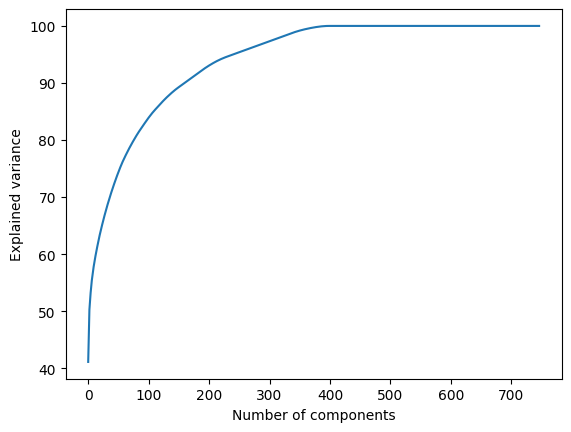

In [24]:
total_components = min(len(X_portered.columns)-1, len(X_portered))
n_components = 300
x_pca = perform_PCA (X_portered, Y_portered, total_components, n_components)

In [25]:
x_final=[x[:300] for x in x_pca]
len(x_final)
len(Y_portered)

5787

In [26]:
x_train, x_test,y_train , y_test=split_data_train_test_split(x_final,Y_portered)
print(len(x_train))
print(len(y_train))

4629
4629


In [27]:
class Data:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

class Result:
    def __init__(self, y_test, y_pred, label=None):
        self.label = label
        self.accuracy = accuracy_score(y_test,y_pred) * 100
        self.precision = precision_score(y_test, y_pred)
        self.recall = recall_score(y_test, y_pred)
        self.f1 = f1_score(y_test, y_pred)
        self.confusion_matrix = confusion_matrix(y_test, y_pred)
        
    def show(self):
        print("Accuracy = ",self.accuracy,"%")
        print("Precision = ",self.precision)
        print("Recall = ",self.recall)
        print("F1 Score = ",self.f1)
        print("Confusion Matrix: \n", self.confusion_matrix)
        
def getResult(data, res):
    result = Result(data.y_test, res)
    result.show()
    return result

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

def getBestModel(data, model, param_grid, cv=10):
    scorer = make_scorer(metrics.recall_score , average='binary')
    grid = GridSearchCV(model, 
                        param_grid,
                        cv=10,
                        scoring=scorer)


    grid.fit(data.x_train, data.y_train)
    
    return grid

In [28]:
data = Data(x_train, y_train, x_test, y_test)

In [ ]:
# SVM
from sklearn.svm import SVC
from sklearn import svm

svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
                  'gamma': [1,0.1,0.01,0.001]
                 } 
svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
#                   'gamma': [1,0.1,0.01,0.001]
                 } 

# svm_param_grid = {'C': [0.1, 0.2, 0.3, 0.5, 1, 2, 3, 5, 10], 
#                   'kernel': ['linear']
#                  }


grid = getBestModel(data, svm.SVC(), svm_param_grid)

y_pred = grid.predict(data.x_test)
getResult(data, y_pred)
grid.best_params_


In [ ]:
# from sklearn.ensemble import RandomForestClassifier

# random_forest_params_grid = {
# #     'n_estimators': [i for i in range(100, 1000, 10)],
#     'n_estimators': [200],
#     'criterion': ['gini', 'entropy'],
# #     'max_features': ['auto', 'sqrt', 'log2'],
# #     'min_samples_leaf': [1, 2, 4],
# #     'min_samples_split': [2, 5, 10],
#     'random_state': [0]
# }

# grid = getBestModel(data, RandomForestClassifier(), random_forest_params_grid)

# y_pred = grid.predict(data.x_test)
# getResult(data, y_pred)
# grid.best_params_

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# decision_tree_params = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [i for i in range(100, 2000, 100)],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'random_state': [0]
# }
# grid = getBestModel(data, DecisionTreeClassifier(), decision_tree_params)

# y_pred = grid.predict(data.x_test)

# getResult(data, y_pred)

# grid.best_params_

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier

# knn_params_grid = {
#     'n_neighbors': [i for i in range(30)],
#     'p': [1,2],
#     'metric' : ['minkowski','euclidean','manhattan', 'cosine', 'chebyshev'],
#     'algorithm': [‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’]
# }

# grid = getBestModel(data, KNeighborsClassifier(), knn_params_grid)

# y_pred = grid.predict(data.x_test)

# getResult(data, y_pred)

# grid.best_params_

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_params_grid = {
    'clf__var_smoothing': [0.00000001, 0.000000001, 0.00000001]
}

grid = getBestModel(data, GaussianNB(), nb_params_grid)

y_pred = grid.predict(data.x_test)

getResult(data, y_pred)

grid.best_params_